In [1]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-21 14:05:51.892677
numcores: 28


In [2]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [3]:
# Working model, inferring mus 

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(pm.Beta.dist(alpha=1,beta=alpha,shape=infinity).random()))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),0,10,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [4]:
trace = pm.sample(draws=5000,tune=1000,cores=8,init='auto',n_init=5,model=model)
print(pm.summary(trace));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu4, mu3, mu2, mu1, mu0, alpha]
Sampling 8 chains, 0 divergences: 100%|██████████| 48000/48000 [22:12<00:00, 36.01draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
alpha   0.995  0.989   0.000    2.769      0.004    0.004   57978.0  38539.0   
w[0]    0.974  0.000   0.974    0.974      0.000    0.000   40000.0  40000.0   
w[1]    0.026  0.000   0.026    0.026      0.000    0.000   40000.0  40000.0   
w[2]    0.000  0.000   0.000    0.000      0.000    0.000   40000.0  40000.0   
w[3]    0.000  0.000   0.000    0.000      0.000    0.000   40000.0  40000.0   
w[4]    0.000  0.000   0.000    0.000      0.000    0.000   40000.0  40000.0   
mu0[0]  1.736  1.989   0.938    7.009      0.703    0.516       8.0      8.0   
mu0[1]  2.768  1.982   1.969    8.018      0.700    0.514       8.0      8.0   
mu0[2]  3.802  1.967   3.011    9.017      0.695    0.510       8.0      8.0   
mu1[0]  6.247  1.989   0.972    7.059      0.703    0.516       8.0      8.0   
mu1[1]  7.262  1.982   2.006    8.071      0.700    0.514       8.0      8.0   
mu1[2]  8.262  1.967   3.047    9.068   

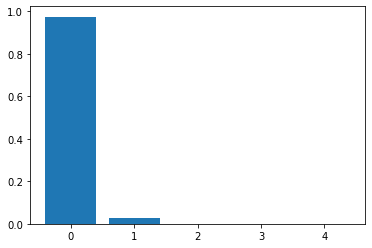

In [5]:
plt.bar(np.arange(infinity),trace['w'].mean(axis=0));

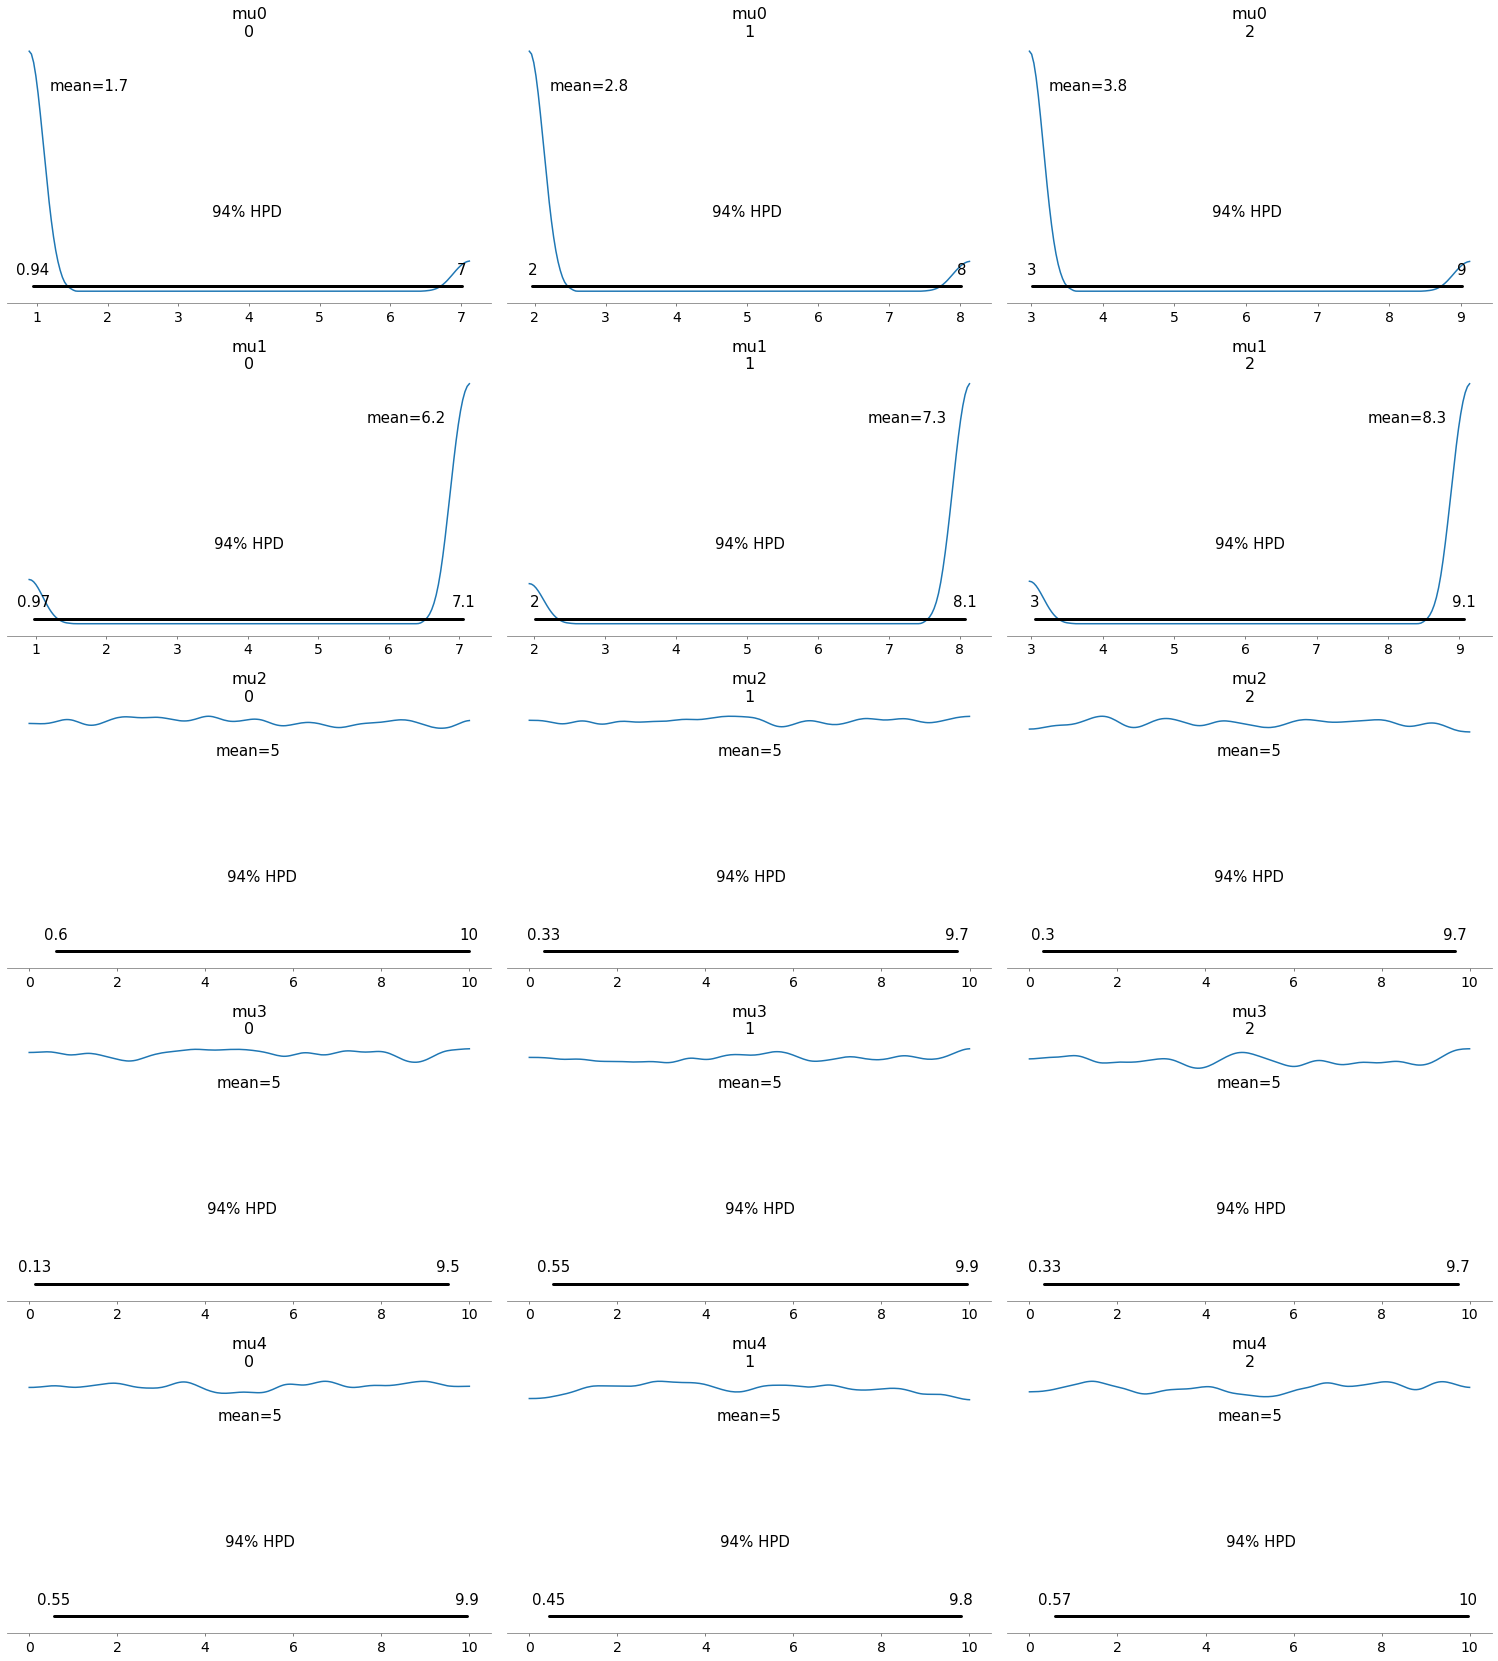

In [6]:
pm.plot_posterior(data=trace,var_names=['mu0','mu1','mu2','mu3','mu4']);
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

In [7]:
t_finish=now()

In [8]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 0:25:58.050587


In [9]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [10]:
#with model:
#    trace = pm.find_MAP()